## Objective:
The goal is to build a machine learning system to automatically evaluate whether a person is eligible for a loan or not.

Importing Nececcery Libar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Preprocessing

Load Data

In [2]:
data = pd.read_csv("data/loan.csv")
data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


#### Handling Missing Values

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [4]:
data[data["Married"].isna()]

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


In [5]:
data["Dependents"] = data["Dependents"].replace("3+","3").astype("Int64")

To improve the handling of missing values, we first separate the data into two groups: approved and rejected applications.

In [6]:
df_approved = data[data["Loan_Status"] == 'Y'].copy()
df_rejected = data[data["Loan_Status"] == 'N'].copy()

print(f"Number of approved: {len(df_approved)}\nNumber of rejevted: {len(df_rejected)}")

Number of approved: 422
Number of rejevted: 192


It is better to impute binary features using the mode and numerical features using the median.

In [7]:
from sklearn.impute import SimpleImputer

binary_cols = ["Gender", "Self_Employed", "Loan_Status", "Credit_History"]
cat_cols = ["Married"]
numeric_cols = ["Dependents", "LoanAmount", "Loan_Amount_Term"]

binary_imputer = SimpleImputer(strategy="most_frequent")
cat_imputer = SimpleImputer(strategy="most_frequent")
numeric_imputer = SimpleImputer(strategy="median")

def preprocess(df):
    df[binary_cols] = binary_imputer.fit_transform(df[binary_cols])
    df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])
    mask = (df["CoapplicantIncome"] != 0) & (df["Married"].isna())
    df.loc[mask, "Married"] = "Yes"
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    return df

df_approved = preprocess(df_approved)
df_rejected = preprocess(df_rejected)

data_clean = pd.concat([df_approved, df_rejected])
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    float64
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    object 
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 62.4+ KB


#### Encoding Categorical Features

In [8]:
from sklearn.preprocessing import LabelEncoder

data_encoded = data_clean.copy() 

binary_cols = ["Gender", "Married", "Education", "Self_Employed","Loan_Status"]
le = LabelEncoder()
for col in binary_cols:
    data_encoded[col] = le.fit_transform(data_encoded[col])

data_encoded["Education"] = 1 - data_encoded["Education"]  # Recode Education: set Graduate = 1 and Not Graduate = 0

data_encoded = pd.get_dummies(data_encoded, columns=["Property_Area"], prefix="Property_Area")

data_encoded.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,0,0.0,1,0,5849,0.0,126.0,360.0,1.0,1,False,False,True
2,1,1,0.0,1,1,3000,0.0,66.0,360.0,1.0,1,False,False,True
3,1,1,0.0,0,0,2583,2358.0,120.0,360.0,1.0,1,False,False,True
4,1,0,0.0,1,0,6000,0.0,141.0,360.0,1.0,1,False,False,True
5,1,1,2.0,1,1,5417,4196.0,267.0,360.0,1.0,1,False,False,True


#### Splitting the Data

In [9]:
from sklearn.model_selection import train_test_split

X = data_encoded.drop("Loan_Status",axis=1)
y = data_encoded["Loan_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training data size:", X_train.shape)
print("Testing data size", X_test.shape)

Training data size: (491, 13)
Testing data size (123, 13)


#### Data Normalization

In [10]:
from sklearn.preprocessing import StandardScaler

numerical_cols = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]

X_train_normalized = X_train.copy()
X_test_normalized = X_test.copy()

scaler = StandardScaler()
X_train_normalized[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_normalized[numerical_cols] = scaler.transform(X_test[numerical_cols])

#### Model Training

#### Logitic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(solver='liblinear')

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']        
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_normalized, y_train)

print("Best Logistic Regression Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Logistic Regression Params: {'C': 0.1, 'penalty': 'l1'}
Best Score: 0.7983714698000413


**Time spent: 0.2s**    
Best Logistic Regression Params: {'C': 0.1, 'penalty': 'l1'}    
Best Score: 0.7983714698000413

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_lr = LogisticRegression(solver="liblinear", C=10, penalty="l1")
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

model_lr_normalized = LogisticRegression(
    solver="liblinear",  # Solver optimized for small datasets and supports L1 penalty
    C=0.1,               # Inverse of regularization strength; smaller values imply stronger regularization
    penalty="l1"         # L1 regularization (Lasso), which can lead to sparse coefficients (feature selection)
)

model_lr_normalized.fit(X_train_normalized, y_train)
y_pred_lr_norm = model_lr_normalized.predict(X_test_normalized)
accuracy_lr_norm = accuracy_score(y_test, y_pred_lr_norm)

print(f"Without normalization: {accuracy_lr}\nWith normalization: {accuracy_lr_norm}")

Without normalization: 0.8617886178861789
With normalization: 0.8536585365853658


### KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_normalized, y_train)

print("Best KNN Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best KNN Params: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}
Best Score: 0.7210265924551639


**Time spent: 0.5s**     
Best Logistic Regression Params: {'C': 0.1, 'penalty': 'l1'}    
Best Score: 0.7983714698000413

In [13]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(n_neighbors=11, weights="uniform", metric="manhattan")
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)

model_knn_normalized = KNeighborsClassifier(
    n_neighbors=7,           # Number of nearest neighbors to use for prediction (k=7)
    weights="uniform",       # All neighbors are weighted equally (no distance-based weighting)
    metric="manhattan"       # Manhattan distance (L1 norm) is used to measure distance between points
)

model_knn_normalized.fit(X_train_normalized, y_train)
y_pred_knn_norm = model_knn_normalized.predict(X_test_normalized)
accuracy_knn_norm = accuracy_score(y_test, y_pred_knn_norm)

print(f"Without normalization: {accuracy_knn}\nWith normalization: {accuracy_knn_norm}")

Without normalization: 0.6747967479674797
With normalization: 0.7398373983739838


#### ANN(MLP)

In [42]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')


mlp_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(early_stopping=True, random_state=42))
])

param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__alpha': [0.0001, 0.001, 0.01], 
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__batch_size': [32, 64, 128],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__max_iter': [200, 300]
}

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1_weighted',
    'roc_auc': 'roc_auc_ovr'
}

mlp_grid = GridSearchCV(
    estimator=mlp_pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

mlp_grid.fit(X_train, y_train)

print("Best MLP Params:", mlp_grid.best_params_)
print("Best Score:", mlp_grid.best_score_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best MLP Params: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 32, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__learning_rate_init': 0.01, 'mlp__max_iter': 200, 'mlp__solver': 'sgd'}
Best Score: 0.7596522133167182


**Time spent: 35.7s**        
Best MLP Params: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__batch_size': 32, 'mlp__hidden_layer_sizes': (50, 50), 'mlp__learning_rate_init': 0.01, 'mlp__max_iter': 200, 'mlp__solver': 'sgd'}     
Best Score: 0.7596522133167182

In [15]:
from sklearn.neural_network import MLPClassifier

model_mlp = MLPClassifier(random_state=42)
model_mlp.fit(X_train, y_train)
y_pred_mlp = model_mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

model_mlp_normalized = MLPClassifier(
    activation='relu',            # Activation function for the hidden layers; 'relu' helps with non-linearity and avoids vanishing gradients
    alpha=0.0001,                 # L2 regularization term to prevent overfitting
    batch_size=32,               # Number of samples per mini-batch during training
    hidden_layer_sizes=(50, 50), # Two hidden layers, each with 50 neurons
    learning_rate_init=0.01,     # Initial learning rate for weight updates
    random_state=42,             # Ensures reproducibility by fixing the random seed
    max_iter=200,                # Maximum number of training iterations (epochs)
    solver='sgd',                # Optimizer used for weight updates; 'sgd' stands for stochastic gradient descent
    early_stopping=True          # Stops training early if validation score doesn't improve, to prevent overfitting
)


model_mlp_normalized.fit(X_train_normalized, y_train)
y_pred_mlp_norm = model_mlp_normalized.predict(X_test_normalized)
accuracy_mlp_norm = accuracy_score(y_test, y_pred_mlp_norm)

print(f"Without normalization: {accuracy_mlp}\nWith normalization: {accuracy_mlp_norm}")

Without normalization: 0.6747967479674797
With normalization: 0.8699186991869918


### Model Comparison

In the **Logistic Regression** model, unlike distance-based models, normalization does not always lead to improved performance. In fact, in our experiment, the model's accuracy was slightly higher without normalization. This may be due to the model's reliance on the original distribution of features and the information embedded in their scales.


In [44]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

models = {
    "Logistic Regression": model_lr_normalized,
    "KNN": model_knn_normalized,
    "MLP": model_mlp_normalized
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    print(f"{name}: Mean = {scores.mean():.3f}, Std = {scores.std():.3f}")

Logistic Regression: Mean = 0.805, Std = 0.025
KNN: Mean = 0.637, Std = 0.029
MLP: Mean = 0.689, Std = 0.003


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



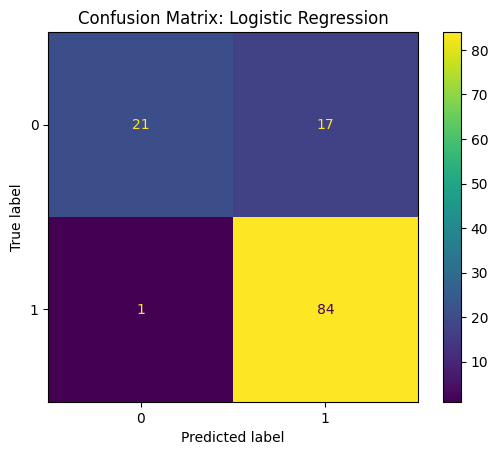

--- K-Nearest Neighbors ---
              precision    recall  f1-score   support

           0       0.71      0.26      0.38        38
           1       0.74      0.95      0.84        85

    accuracy                           0.74       123
   macro avg       0.73      0.61      0.61       123
weighted avg       0.73      0.74      0.70       123



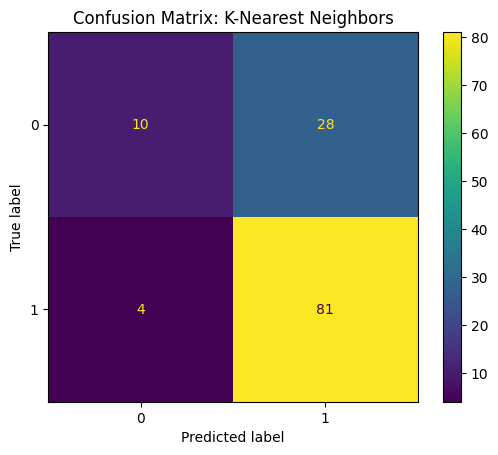

--- MLP Neural Network ---
              precision    recall  f1-score   support

           0       0.96      0.61      0.74        38
           1       0.85      0.99      0.91        85

    accuracy                           0.87       123
   macro avg       0.90      0.80      0.83       123
weighted avg       0.88      0.87      0.86       123



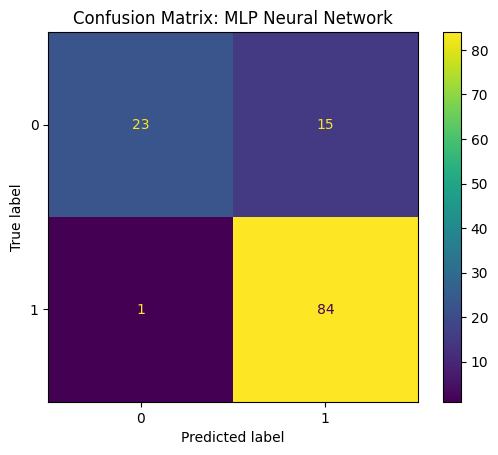


📊 Summary of Model Performance:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC
0  Logistic Regression  0.853659   0.831683  0.988235  0.903226  0.836068
1  K-Nearest Neighbors  0.739837   0.743119  0.952941  0.835052  0.763467
2   MLP Neural Network  0.869919   0.848485  0.988235  0.913043  0.835913


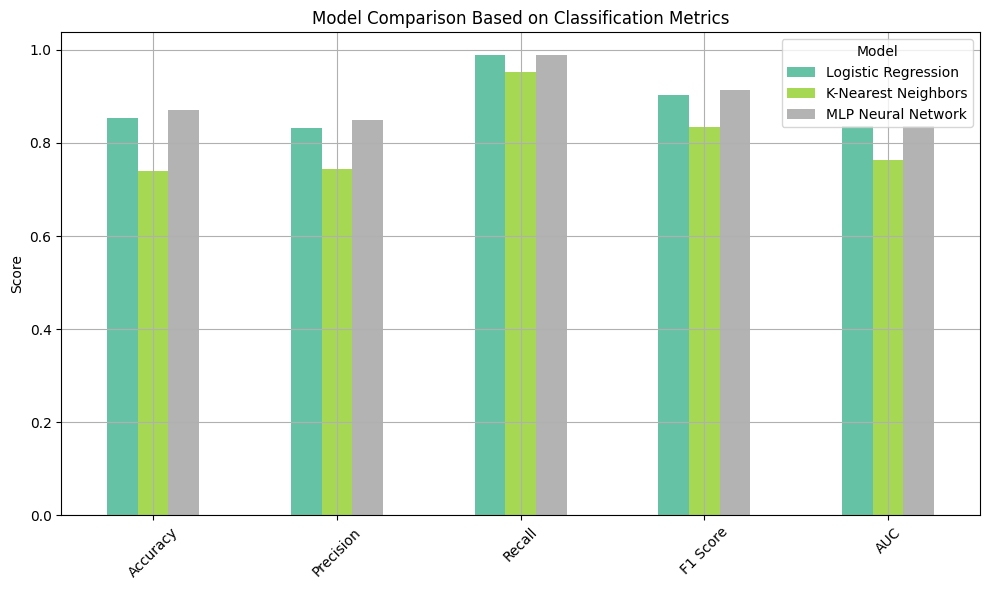

In [45]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report,
    ConfusionMatrixDisplay
)

models = {
    "Logistic Regression": model_lr_normalized,
    "K-Nearest Neighbors": model_knn_normalized,
    "MLP Neural Network": model_mlp_normalized
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_normalized)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_normalized)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_normalized)
    else:
        y_proba = None

    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='binary'),
        "Recall": recall_score(y_test, y_pred, average='binary'),
        "F1 Score": f1_score(y_test, y_pred, average='binary'),
        "AUC": auc
    })

    print(f"--- {name} ---")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

results_df = pd.DataFrame(results)
print("\n📊 Summary of Model Performance:")
print(results_df)

results_df.set_index("Model").T.plot(kind="bar", figsize=(10, 6), colormap="Set2")
plt.title("Model Comparison Based on Classification Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Test Models on Test Dataset

In [46]:
test_data = pd.read_csv("data/test.csv")
test_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [47]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             356 non-null    object 
 1   Married            367 non-null    object 
 2   Dependents         357 non-null    object 
 3   Education          367 non-null    object 
 4   Self_Employed      344 non-null    object 
 5   ApplicantIncome    367 non-null    int64  
 6   CoapplicantIncome  367 non-null    int64  
 7   LoanAmount         362 non-null    float64
 8   Loan_Amount_Term   361 non-null    float64
 9   Credit_History     338 non-null    float64
 10  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(6)
memory usage: 31.7+ KB


In [48]:
clean_test_data = test_data.copy()

clean_test_data["Dependents"] = data["Dependents"].replace("3+","3").astype("Int64")

binary_cols = ["Gender", "Self_Employed", "Credit_History"]
other_cols = ["Dependents", "LoanAmount", "Loan_Amount_Term"]

clean_test_data = preprocess(clean_test_data)    

clean_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             367 non-null    object 
 1   Married            367 non-null    object 
 2   Dependents         367 non-null    float64
 3   Education          367 non-null    object 
 4   Self_Employed      367 non-null    object 
 5   ApplicantIncome    367 non-null    int64  
 6   CoapplicantIncome  367 non-null    int64  
 7   LoanAmount         367 non-null    float64
 8   Loan_Amount_Term   367 non-null    float64
 9   Credit_History     367 non-null    object 
 10  Property_Area      367 non-null    object 
dtypes: float64(3), int64(2), object(6)
memory usage: 31.7+ KB


In [49]:
encoded_test_data = clean_test_data.copy()

from sklearn.preprocessing import LabelEncoder

binary_cols = ["Gender", "Married", "Education", "Self_Employed"]
le = LabelEncoder()
for col in binary_cols:
    encoded_test_data[col] = le.fit_transform(encoded_test_data[col])

encoded_test_data["Education"] = 1 - encoded_test_data["Education"]

encoded_test_data = pd.get_dummies(encoded_test_data, columns=["Property_Area"], prefix="Property_Area")

encoded_test_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,1,0.0,1,0,5720,0,110.0,360.0,1.0,False,False,True
1,1,1,1.0,1,0,3076,1500,126.0,360.0,1.0,False,False,True
2,1,1,0.0,1,0,5000,1800,208.0,360.0,1.0,False,False,True
3,1,1,0.0,1,0,2340,2546,100.0,360.0,1.0,False,False,True
4,1,0,0.0,0,0,3276,0,78.0,360.0,1.0,False,False,True


In [50]:
X_test_ = encoded_test_data.copy()

print("Logistic:", np.bincount(model_lr_normalized.predict(X_test_)))
print("KNN:", np.bincount(model_knn_normalized.predict(X_test_)))
print("ANN:", np.bincount(model_mlp_normalized.predict(X_test_)))


Logistic: [232 135]
KNN: [ 86 281]
ANN: [200 167]


## 🧾 Model Performance Evaluation and Selection Report

### 🔍 Evaluation Summary

Three classification models were trained and evaluated for a binary classification task. Performance was assessed using a standard **train/test split** as well as **5-fold stratified cross-validation (CV)** to evaluate generalization.

#### 📊 Performance (Train/Test Split)

| Model               | Accuracy  | Precision | Recall | F1 Score  | AUC   |
| ------------------- | --------- | --------- | ------ | --------- | ----- |
| Logistic Regression | 0.854     | 0.832     | 0.988  | 0.903     | 0.836 |
| K-Nearest Neighbors | 0.740     | 0.743     | 0.953  | 0.835     | 0.763 |
| MLP Neural Network  | **0.870** | 0.848     | 0.988  | **0.913** | 0.836 |

#### 📈 Cross-Validation (5-Fold Stratified CV)

| Model               | Mean Accuracy | Std Dev |
| ------------------- | ------------- | ------- |
| Logistic Regression | **0.805**     | ±0.025  |
| K-Nearest Neighbors | 0.637         | ±0.029  |
| MLP Neural Network  | 0.689         | ±0.003  |

---

### 📌 Class Prediction Distributions on Test Set

| Model               | Predicted \[0, 1] |
| ------------------- | ----------------- |
| Logistic Regression | \[232, 135]       |
| K-Nearest Neighbors | \[86, 281]        |
| MLP Neural Network  | \[200, 167]       |

> ⚠️ Note: Class `1` represents the **positive class** (e.g., loan approved).

---

### 🧠 Interpretation

#### ✅ **MLP Neural Network**

* Achieved the **highest accuracy and F1 score** on the test set.
* Maintains a **high recall (0.988)**, meaning very few false negatives.
* **BUT**, it shows **low cross-validation performance (Mean = 0.689)**, suggesting **possible overfitting** to the train/test split.
* Class prediction ratio \[200, 167] is fairly balanced, which is good.

#### ✅ **Logistic Regression**

* Slightly lower accuracy on the test set (0.854 vs. 0.870), but still strong overall.
* **Most stable and reliable model** with the highest CV accuracy (0.805 ± 0.025).
* Very **high recall (0.988)** and solid precision and AUC.
* Predicted class distribution \[232, 135] is balanced and realistic.

#### ⚠️ **K-Nearest Neighbors**

* Performs significantly worse in both CV and test split.
* Class distribution \[86, 281] shows **strong class imbalance**, overpredicting class `1`.
* Least reliable for generalization.

---

### ✅ Final Decision: **Best Model**

While the **MLP Neural Network** appears strongest on the test set, its **poor cross-validation performance** and potential overfitting are red flags.

> **Therefore, the recommended final model is: 🔹 Logistic Regression**

#### Why?

* Consistently high performance across metrics
* Strong **generalization** (highest CV accuracy)
* Balanced predictions
* Simpler, interpretable, and computationally efficient